In [29]:
import sys
sys.path.insert(0, "/home/matheus/projects/marioai")

from marioai.core import Runner
from marioai.agents import BaseAgent
import pandas as pd
import numpy as np
import random
from copy import deepcopy
import matplotlib.pyplot as plt
from tqdm import tqdm

In [61]:
class State():
    def __init__(self, **kwargs):
        self.state_attrs = []
        for key, value in kwargs.items():
            setattr(self, key, value)
            self.state_attrs.append(key)
    
    def __repr__(self):
        repr_str = "State("
        for attr in self.state_attrs:
            repr_str += f"{attr}={getattr(self, attr)}, "
        return repr_str
    def __hash__(self):
        attrs = []
        for attr in self.state_attrs:
            attrs.append(attr)
        return hash(tuple(attrs))

    def __eq__(self, other):
        for attr in self.state_attrs:
            if getattr(self, attr) != getattr(other, attr):
                return False
        return True
        
class MonteCarloAgent(BaseAgent):

    def __init__(self, n_samples, discount, min_epsilon=0.3):
        super().__init__()
        self.n_samples = n_samples
        self.discount = discount
        self.in_fit = False
        self.min_epsilon = min_epsilon
        self.epsilon = 1
        self.value_func = {}
        self._N = {}
        self._S = {}
        self._Q = {}
        self.actions_idx = []
        self.fit_rewards = []

    def compute_reward(self, reward_data):
        if reward_data["status"] == 1:
            return reward_data["distance"]
        if "distance" in reward_data:
            return reward_data["distance"] * 1e-1
        return 0
    def policy(self, state, kind="random"):
        
        if kind == "random":
            action_idx = np.random.randint(self._Q[state].shape[0])
        elif kind == "greedy":
            action_idx = self._Q[state].argmax()
        elif kind == "e_greedy":
            if np.random.random() > self.epsilon:
                action_idx = self._Q[state].argmax()
            else:
                action_idx = np.random.randint(self._Q[state].shape[0])
        self.actions_idx.append(action_idx)
        return action_idx

    def filter_actions(self) -> np.array:
        """This function filter the action pool"""
        action_pool = np.copy(self._action_pool)
        return action_pool

    def _fit_act(self, action_pool):
        state = State(**self.state)
        if state not in self._Q:
            self._Q[state] = np.zeros(action_pool.shape[0])
        action_idx = self.policy(state, kind="e_greedy")
        action = action_pool[action_idx].tolist()
        return action

    def act(self):
        action_pool = self.filter_actions()
        if self.in_fit:
            action = self._fit_act(action_pool)
        else:
            state = State(**self.state)
            if state not in self._Q:
                self._Q[state] = np.zeros(action_pool.shape[0])
            action_idx = self.policy(state, kind="greedy")
            action = action_pool[action_idx].tolist()
        self.actions.append(action)
        return action

    def fit(self, **runner_kwargs):
        self.in_fit = True
        runner = Runner(self, **runner_kwargs)
        self.epsilon = 1.
        for k in (pbar :=tqdm(range(self.n_samples), total=self.n_samples)):
            runner.run()
            self.fit_rewards.append(self._step())
            self.epsilon = max(self.min_epsilon, self.epsilon - 1/(self.n_samples))
            pbar.set_description(f"Last Reward {self.fit_rewards[-1]:.2f} Epsilon: {self.epsilon:.3f}")
            pbar.refresh()

        runner.close()
        self.in_fit = False
        return self

    def reset(self):
        self.states = []
        self.rewards =  []
        self.actions = []
        self.actions_idx = []

    def _step(self):
        
        visited_states = []
        rewards = np.array(list(map(self.compute_reward, self.rewards)))
        prev_Q = deepcopy(self._Q)
        for i, (state_dict, action) in enumerate(zip(self.states, self.actions_idx)):
            state = State(**state_dict)
            if state not in visited_states:
                visited_states.append(state)
            if state not in self._N:
               self._N[state] = np.zeros(self._Q[state].shape[0])
            self._N[state][action] += 1
            future_rewards = rewards[i:]
            discounts = np.array([self.epsilon ** k for k in range(future_rewards.shape[0])])
            g_t = np.dot(discounts, future_rewards)/self.n_samples
            q_value = prev_Q[state][action]
            self._Q[state][action] = q_value + (1/self._N[state][action])*(g_t - q_value)
        return rewards.sum()

In [66]:
mc_model = MonteCarloAgent(80, 0.99, min_epsilon=0.5)
mc_model = mc_model.fit(level_difficult=0, mario_mode=0, time_limit=100, response_delay=0, max_fps=360)

/home/matheus/projects/marioai/notebooks
Connection attempt: 1/5
Connection attempt: 2/5
Connection attempt: 3/5


Last Reward 36.66 Epsilon: 0.775:  22%|██▎       | 18/80 [02:10<07:28,  7.23s/it]


KeyboardInterrupt: 

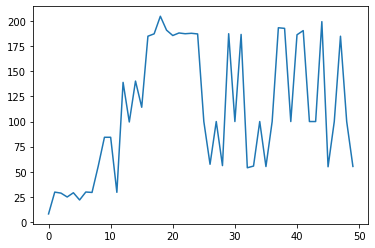

In [63]:

plt.plot(range(len(mc_model.fit_rewards)), mc_model.fit_rewards)

In [65]:
runner = Runner(mc_model, level_difficult=0, mario_mode=0, time_limit=100, response_delay=0, max_fps=24)
runner.run()
runner.close()

/home/matheus/projects/marioai/notebooks
Connection attempt: 1/5
Connection attempt: 2/5
Connection attempt: 3/5


KeyboardInterrupt: 